In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib widget
from eitprocessing.datahandling.loading import load_eit_data
from eitprocessing.features.breath_detection import BreathDetection
from eitprocessing.features.pixel_breath import PixelBreath
from eitprocessing.parameters.tidal_impedance_variation import TIV

### Load a sequence from file.

In [2]:
sequence = load_eit_data("tests/test_data/Draeger_Test.bin", vendor="draeger")

### Select a small portion of the sequence

In [3]:
ssequence = sequence.t[55940:55970]

### Perform breath detection on global impedance

In [4]:
bd = BreathDetection()
breaths = bd.find_breaths(ssequence.continuous_data["global_impedance_(raw)"])

In [5]:
continuous_data = ssequence.continuous_data["global_impedance_(raw)"].values

continuous_start_indices = [
    np.argmax(ssequence.continuous_data["global_impedance_(raw)"].time == start_time)
    for start_time in [breath.start_time for breath in breaths.values]
]
continuous_middle_indices = [
    np.argmax(ssequence.continuous_data["global_impedance_(raw)"].time == middle_time)
    for middle_time in [breath.middle_time for breath in breaths.values]
]
continuous_end_indices = [
    np.argmax(ssequence.continuous_data["global_impedance_(raw)"].time == end_time)
    for end_time in [breath.end_time for breath in breaths.values]
]

### Perform pixel breath detection on pixel impedance

In [6]:
pb = PixelBreath()
pixel_breaths = pb.find_pixel_breaths(
    eit_data=ssequence.eit_data["raw"],
    continuous_data=ssequence.continuous_data["global_impedance_(raw)"],
    sequence=ssequence,
)

In [7]:
pixel_data = ssequence.eit_data["raw"].pixel_impedance
pixel_breaths = np.stack(pixel_breaths.values)

# Handle None values
pixel_start_indices = [
    np.argmax(ssequence.eit_data["raw"].time == start_time)
    for pixel_breath in pixel_breaths[:, 12, 13]
    if pixel_breath is not None
    for start_time in [pixel_breath.start_time]
]

pixel_middle_indices = [
    np.argmax(ssequence.eit_data["raw"].time == middle_time)
    for pixel_breath in pixel_breaths[:, 12, 13]
    if pixel_breath is not None
    for middle_time in [pixel_breath.middle_time]
]

pixel_end_indices = [
    np.argmax(ssequence.eit_data["raw"].time == end_time)
    for pixel_breath in pixel_breaths[:, 12, 13]
    if pixel_breath is not None
    for end_time in [pixel_breath.end_time]
]

### Compute TIV with different TIV methods and timings

In [8]:
# TIV of global impedance determined on inspiratory limb of breath
tiv_result_continuous_inspiratory = TIV().compute_continuous_parameter(
    ssequence.continuous_data["global_impedance_(raw)"],
)

# TIV of global impedance determined on expiratory limb of breath
tiv_result_continuous_expiratory = TIV().compute_continuous_parameter(
    ssequence.continuous_data["global_impedance_(raw)"],
    tiv_method="expiratory",
)
# TIV of global impedance determined on mean of inspiratory and expiratory limb of breath
tiv_result_continuous_mean = TIV().compute_continuous_parameter(
    ssequence.continuous_data["global_impedance_(raw)"],
    tiv_method="mean",
)

# TIV of pixel impedance determined on inspiratory limb of pixel breath based on pixel breath timings
tiv_result_pixel_inspiratory = TIV().compute_pixel_parameter(
    ssequence.eit_data["raw"],
    ssequence.continuous_data["global_impedance_(raw)"],
    ssequence,
    tiv_method="inspiratory",
    tiv_timing="pixel",
)
# TIV of pixel impedance determined on inspiratory limb of pixel breath based on continuous breath timings
tiv_result_pixel_inspiratory_continuous_timing = TIV().compute_pixel_parameter(
    ssequence.eit_data["raw"],
    ssequence.continuous_data["global_impedance_(raw)"],
    ssequence,
    tiv_method="inspiratory",
    tiv_timing="continuous",
)

### Visualise global impedance TIV

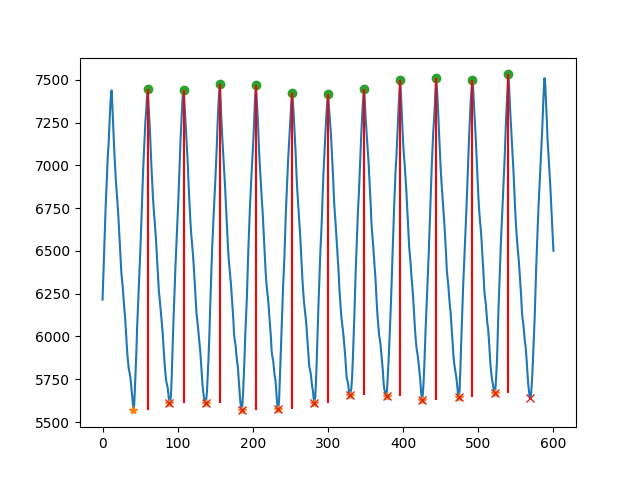

In [13]:
## Plot results of inspiratory TIV method on global impedance

plt.figure()
plt.plot(continuous_data)
plt.plot(continuous_start_indices, continuous_data[continuous_start_indices], "*")
plt.plot(continuous_middle_indices, continuous_data[continuous_middle_indices], "o")
plt.plot(continuous_end_indices, continuous_data[continuous_end_indices], "x")

# Plot vertical lines at middle_indices
for i, mid_idx in enumerate(continuous_middle_indices):
    plt.vlines(
        x=mid_idx,
        ymin=continuous_data[mid_idx] - tiv_result_continuous_inspiratory[i],
        ymax=continuous_data[mid_idx],
        color="r",
        linestyle="-",
        label="TIV",
    )

### Visualise pixel TIV based on pixel breath timings

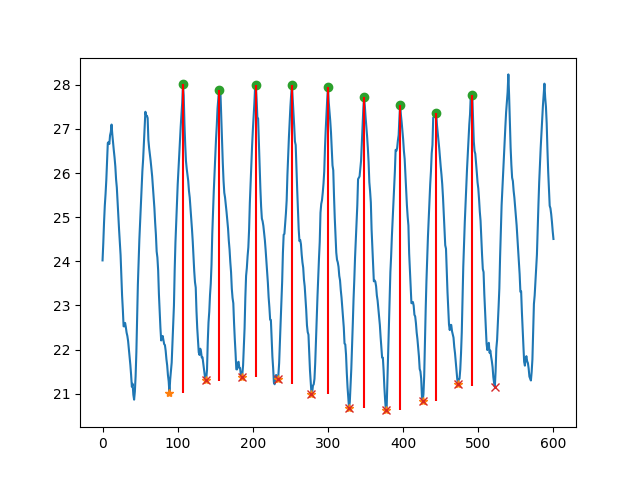

In [9]:
## Plot results of inspiratory TIV method of a single pixel

pixel_row = 12
pixel_col = 12

pixel_data = ssequence.eit_data["raw"].pixel_impedance

plt.figure()
plt.plot(pixel_data[:, pixel_row, pixel_col])
plt.plot(pixel_start_indices, pixel_data[pixel_start_indices, pixel_row, pixel_col], "*")
plt.plot(pixel_middle_indices, pixel_data[pixel_middle_indices, pixel_row, pixel_col], "o")
plt.plot(pixel_end_indices, pixel_data[pixel_end_indices, pixel_row, pixel_col], "x")

# Plot vertical lines at middle_indices
for i, mid_idx in enumerate(pixel_middle_indices):
    plt.vlines(
        x=mid_idx,
        ymin=pixel_data[mid_idx, pixel_row, pixel_col] - tiv_result_pixel_inspiratory[i + 1, pixel_row, pixel_col],
        ymax=pixel_data[mid_idx, pixel_row, pixel_col],
        color="r",
        linestyle="-",
        label="TIV",
    )

### Visualise pixel TIV based on continuous breaths timings

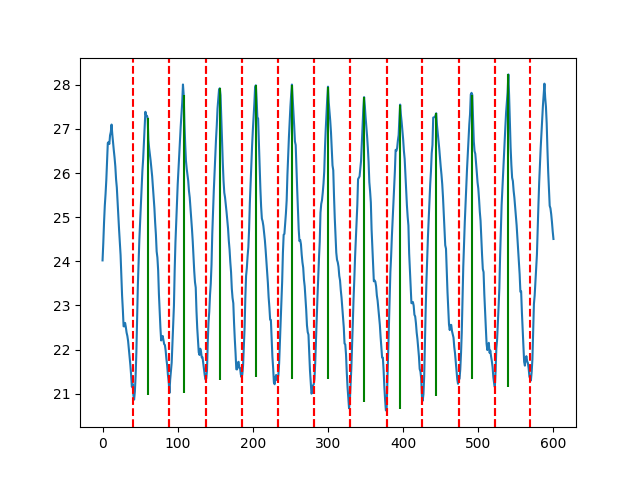

In [15]:
## Plot results of inspiratory TIV method of a single pixel based on the timing of the continuous breaths
plt.figure()
plt.plot(pixel_data[:, pixel_row, pixel_col])

for i, glo_mid_idx in enumerate(continuous_middle_indices):
    plt.vlines(
        x=glo_mid_idx,
        ymin=pixel_data[glo_mid_idx, pixel_row, pixel_col]
        - tiv_result_pixel_inspiratory_continuous_timing[i, pixel_row, pixel_col],
        ymax=pixel_data[glo_mid_idx, pixel_row, pixel_col],
        color="g",
        linestyle="-",
        label="TIV",
    )

for i in range(len(continuous_start_indices)):
    plt.axvline(continuous_start_indices[i], color="red", ls="--")
    plt.axvline(continuous_end_indices[i], color="red", ls="--")